### Library Preparation

In [1]:
!pip install -r requirements.txt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
import time
import folium
from folium import plugins
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
!pip install geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

  Using cached MarkupSafe-2.1.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.0
    Not uninstalling markupsafe at /shared-libs/python3.9/py-core/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
2023-05-02 23:32:10.605113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 23:32:10.715747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot ope

In [2]:
io_group = pd.read_csv("/work/BDPNN IO GROUP - BDPNN IO GROUP Cleaned.csv")
io_group.head()

,ioEmail,io Name,ioName-in Contacts,JoinDate
0,aclottman@gmail.com,Andrew Lottman,NaN,12/1/2021
1,stburto@icloud.com,Steve Burton,NaN,11/14/2021
2,AlexR@currently.com,NaN,NaN,10/29/2021
3,matt@mbhansen.com,Matt Hansen,NaN,9/14/2021
4,demeterjan819@gmail.com,Jan,"Murota, Jan",8/25/2021


In [3]:
block_group = pd.read_csv("/work/BLOCK GROUPS - BLOCK GROUPS cleaned.csv")
block_group

,GroupID,BlockName-Short,BlockName-Full,BlockLocation,BlockGrpDetails,Neighborhood,FireDistrict,FireDistrictLocation,Org Level,StageCode,MAP-Staff,Added from,Date Added
0,A10,Acton-1300-1400,Acton Earthquake Action,1300-1400 block of Action btwn Gilman&creek/de...,NaN,Central,6,"999 Cedar Street, 94710",O,2,green,Lynn Email,8/2/2011
1,A12,Acton-Francisco,Acton between Francisco-Delaware,1700 block,NaN,Central,6,"999 Cedar Street, 94710",O,1,?,Meeting 4-2-09,4/9/2009
2,A123,Acton-2200,2200 Acton/Bancroft Ct,Acton between Allston&Bancroft,NaN,Central,1,"2442 Eighth Street, 94710",O,1,?,Meeting 8-31-09,9/27/2009
3,A124,Acton-Allston,Acton-Allston,?,NaN,Central,1,"2442 Eighth Street, 94710",?,?,?,?,3/7/2009
4,A13,Ada-Ordway CERT,Ada-Ordway-Acton,"Ada, Rose to Hopkins&Miramonte Ct; Sacto fr Ro...",NaN,Central,6,"999 Cedar Street, 94710",O,2,red,Email,3/7/2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,ZZ9-Newark,"Newark resident, work address",NaN,NaN,NaN,NaN,zna,,z,z,zna,NaN,NaN
282,ZZ9-Oakland,Oakland resident,NaN,NaN,NaN,NaN,zna,,z,z,zna,NaN,NaN
283,ZZ9-Rich,Richmond Disaster Prep,Richmond,Richmond,NaN,NaN,zna,,z,z,zna,NaN,NaN
284,ZZ9-WalnutCrk,Walnut Creek residents,NaN,NaN,NaN,NaN,zna,,z,z,zna,NaN,NaN


In [4]:
contacts = pd.read_csv("/work/CONTACTS - CONTACTS cleaned.csv")
contacts.head()

,ContactID,GroupID,ContactName,ContactRole,ContactAddress,Contact cross streets,ContactZip,ContactCity,ContactPhone1,ContactPhone2,ContactEmail1-Master,Date Added,Source,DiscGrp Io
0,109,N54,"Abecassis, Andree",NaN,756 Neilson,Washington,94707,Berkeley,NaN,NaN,aalitagent@aol.com,3/7/2009,Pam Grossman,no
1,1380,ZZ9-Fire 1,"Abeysekera, Dharini",NaN,1322C Haskell St.,Haskell & Mabel,94703,Berkeley,510,510,ndharini@gmail.com,8/5/2019,So Berk Fair 7-28-19,no
2,1367,ZZ9-Fire 4,"Abrams, Barbara",NaN,1909 Vine Street,MLK,94709,Berkeley,510,510,mandala444@gmail.com,7/21/2019,Website 7-20-19,no
3,614,K56,"Abrohms, Jan/Jack",NaN,NaN,NaN,NaN,Berkeley,510,510,JaninCa717@gmail.com,6/17/2013,Meeting 5-30-13,no
4,1105,ZSS2017,"Ackerman, Byron",NaN,NaN,NaN,NaN,NaN,510,510,byron.w.ackerman@gmail.com,9/19/2017,Solano Stroll 9-10-17,no


### Merge block_group with contacts to get contacts_merged dataset:

In [5]:
# Convert date to datatime type and clean contacts data a bit
contacts['Date'] = pd.to_datetime(contacts['Date Added']).dt.date
contacts_cleaned = contacts.sort_values(by=["Date"], ascending=False).reset_index()
contacts_cleaned.head()

,index,ContactID,GroupID,ContactName,ContactRole,ContactAddress,Contact cross streets,ContactZip,ContactCity,ContactPhone1,ContactPhone2,ContactEmail1-Master,Date Added,Source,DiscGrp Io,Date
0,456,1612,S89,"Hess, Lori",NaN,620 Santa Rosa Avenue,NaN,94707,Berkeley,510,510,loribhess@gmail.com,11/6/2021,Website 11-3-21,No,2021-11-06
1,714,1611,V55,"Morrill, Alisa",NaN,663 Vincente Avenue,NaN,94707,Berkeley,510,510,awmorrill@gmail.com,10/11/2021,Website 10-4-21,no,2021-10-11
2,780,1610,ZZ9-Fire 3,"Peters, Kristi",NaN,2828 Palm Court,Stuart Street,94705,Berkeley,510,510,berkeleypalmquarters@gmail.com,9/20/2021,Website 9-20-21,No,2021-09-20
3,601,1609,S89.6,"Lewenstein, Joel",NaN,1836 Sonoma Avenue,Josephine/Colusa,94707,Berkeley,510,510,joel.lewenstein@gmail.com,9/17/2021,Website 9-16-21,no,2021-09-17
4,572,1608,S125,"Laskowski, Linda",NaN,817 San Diego Road,Indian Rock,94707,Berkeley,510,510,llaskowski12@comcast.net,9/1/2021,Website 8-31-21,yes,2021-09-01


Contacts are those who signed up for email list. We can see that the latest join date for contacts is 2021-11-06. The members joined email list from 2008-07-08 till 2021-11-06.

In [6]:
contacts_merged = contacts_cleaned.merge(block_group, on='GroupID')
contacts_merged

,index,ContactID,GroupID,ContactName,ContactRole,ContactAddress,Contact cross streets,ContactZip,ContactCity,ContactPhone1,...,BlockLocation,BlockGrpDetails,Neighborhood,FireDistrict,FireDistrictLocation,Org Level,StageCode,MAP-Staff,Added from,Date Added_y
0,456,1612,S89,"Hess, Lori",NaN,620 Santa Rosa Avenue,NaN,94707,Berkeley,510,...,all of Santa Rosa Avenue-btwn San Lor & Thous ...,NaN,Thousand Oaks,4,"1900 Marin Avenue, 94707",CC,4,blue,CN list,7/9/2008
1,99,777,S89,"Botello, Mike",NaN,606 San Miguel,NaN,94707,Berkeley,510,...,all of Santa Rosa Avenue-btwn San Lor & Thous ...,NaN,Thousand Oaks,4,"1900 Marin Avenue, 94707",CC,4,blue,CN list,7/9/2008
2,100,649,S89,"Botello, Tita",NaN,606 San Miguel,NaN,94707,Berkeley,510,...,all of Santa Rosa Avenue-btwn San Lor & Thous ...,NaN,Thousand Oaks,4,"1900 Marin Avenue, 94707",CC,4,blue,CN list,7/9/2008
3,655,57,S89,"Margolies, Les",Co-Leader,653 Santa Rosa Ave,NaN,94707,Berkeley,510-527-3890,...,all of Santa Rosa Avenue-btwn San Lor & Thous ...,NaN,Thousand Oaks,4,"1900 Marin Avenue, 94707",CC,4,blue,CN list,7/9/2008
4,714,1611,V55,"Morrill, Alisa",NaN,663 Vincente Avenue,NaN,94707,Berkeley,510,...,600 block Vincente btwn Thousand Oaks&Colusa,c 25 houses,Thousand Oaks,4,"1900 Marin Avenue, 94707",O,3,red,TONA 2-12-09,2/17/2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,641,7,J68,"Maestre, Janet",Block Captain,1222 Josephine,NaN,NaN,Berkeley,510-524-2569,...,1200&1300 Josephine blocks; 1400 Grant block (...,NaN,Central,4,"1900 Marin Avenue, 94707",CC,4,blue,CN list,7/9/2008
1106,18,24,J68,"Anderson, Marion",Co-organizer,NaN,NaN,NaN,Berkeley,NaN,...,1200&1300 Josephine blocks; 1400 Grant block (...,NaN,Central,4,"1900 Marin Avenue, 94707",CC,4,blue,CN list,7/9/2008
1107,329,14,D35,"Freed, Ellen B",Block Captain,NaN,NaN,NaN,Berkeley,NaN,...,Delaware btwn San Pablo&Curtis,NaN,Central,6,"999 Cedar Street, 94710",?,?,?,CN list,7/9/2008
1108,668,8,N76,"Maxwell, Jenny",Co-Leader,2535 Hawthorne Terrace,NaN,94708,Berkeley,510-540-8726,...,Euclid btwn Hawthorne Terr&Buena Vista Wy; Bue...,39 hsehlds,Northeast,4,"1900 Marin Avenue, 94707",CC,4,blue,CN list,7/9/2008


### Visualize - geopandas:

In [8]:
locator = Nominatim(user_agent='myGeocoder')
geolocator = Nominatim(user_agent="my_user_agent")
contacts_cleaned['Final Address'] = contacts_cleaned['ContactAddress'] + ', ' + contacts_cleaned['ContactCity'] + ', CA'
contacts_cleaned.dropna(axis='index', subset=['Final Address'])

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


,index,ContactID,GroupID,ContactName,ContactRole,ContactAddress,Contact cross streets,ContactZip,ContactCity,ContactPhone1,ContactPhone2,ContactEmail1-Master,Date Added,Source,DiscGrp Io,Date,Final Address
0,456,1612,S89,"Hess, Lori",NaN,620 Santa Rosa Avenue,NaN,94707,Berkeley,510,510,loribhess@gmail.com,11/6/2021,Website 11-3-21,No,2021-11-06,"620 Santa Rosa Avenue, Berkeley, CA"
1,714,1611,V55,"Morrill, Alisa",NaN,663 Vincente Avenue,NaN,94707,Berkeley,510,510,awmorrill@gmail.com,10/11/2021,Website 10-4-21,no,2021-10-11,"663 Vincente Avenue, Berkeley, CA"
2,780,1610,ZZ9-Fire 3,"Peters, Kristi",NaN,2828 Palm Court,Stuart Street,94705,Berkeley,510,510,berkeleypalmquarters@gmail.com,9/20/2021,Website 9-20-21,No,2021-09-20,"2828 Palm Court, Berkeley, CA"
3,601,1609,S89.6,"Lewenstein, Joel",NaN,1836 Sonoma Avenue,Josephine/Colusa,94707,Berkeley,510,510,joel.lewenstein@gmail.com,9/17/2021,Website 9-16-21,no,2021-09-17,"1836 Sonoma Avenue, Berkeley, CA"
4,572,1608,S125,"Laskowski, Linda",NaN,817 San Diego Road,Indian Rock,94707,Berkeley,510,510,llaskowski12@comcast.net,9/1/2021,Website 8-31-21,yes,2021-09-01,"817 San Diego Road, Berkeley, CA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,274,23,S78,"Edwards, Tom",Co-Leader,47 Alamo Ave,Spruce,94708,Berkeley,510-525-4064,NaN,twedwards47@sbcglobal.net,7/9/2008,Orig CN list,yes,2008-07-09,"47 Alamo Ave, Berkeley, CA"
1103,668,8,N76,"Maxwell, Jenny",Co-Leader,2535 Hawthorne Terrace,NaN,94708,Berkeley,510-540-8726,NaN,jenny@thecatspjs.com,7/9/2008,Orig CN list,no,2008-07-09,"2535 Hawthorne Terrace, Berkeley, CA"
1105,700,26,R78,"Minor, Jeanie",Block Captain,1409 Holly St,Rose/Cedar,94703,Berkeley,510-526-4031,NaN,njminor@comcast.net,7/9/2008,Orig CN list,yes,2008-07-09,"1409 Holly St, Berkeley, CA"
1106,990,4,N78,"Trippe, Tom",Captain,1551 La Vereda Rd,NaN,94708,Berkeley,510-529-5721,510-841-0262,trippe@dslextreme.com,7/8/2008,Orig CN list,yes,2008-07-08,"1551 La Vereda Rd, Berkeley, CA"


In [9]:
contacts_cleaned['Final Address'] = contacts_cleaned['Final Address'].str.replace(r'\s+(?:[Aa]pt|[Uu]nit)\s*\d+,', '', regex=True)

The data has been exported as csv called contacts_cleaned_laglon.csv listed on the right.

Below cell only need to be run once and is commented for now.

In [10]:
# # Warning: this cell will take 20-30 min to run
# # Create a sample map centered around the geographical center of Contra Costa County
# center_address = ''
# # get location information for address
# locator = Nominatim(user_agent="myGeocoder")
# latitude_list = {}
# longitude_list = {}

# retries = 0
# for row in contacts_cleaned['Final Address']:
#     try:
#         # Your code that may raise an error goes here
#         center_address = row
#         print("current processing: ", center_address)
#         center = locator.geocode(center_address)
#         time.sleep(1)
#         if center == None:
#             latitude_list[row] = ""
#             longitude_list[row] = ""
#             continue
#         latitude_list[row] = center.latitude
#         longitude_list[row] = center.longitude
#     except Exception as e:
#         retries += 1
#         print("retry times: ", retries)
#         continue

# # add lat column and long column to the dataframe
# contacts_cleaned['Latitude'] = contacts_cleaned['Final Address']
# contacts_cleaned['Longitude'] = contacts_cleaned['Final Address']
# contacts_cleaned['Latitude'] = contacts_cleaned['Latitude'].map(latitude_list)
# contacts_cleaned['Longitude'] = contacts_cleaned['Longitude'].map(longitude_list)

In [11]:
# contacts_cleaned is now updated with lon and lag columns added
contacts_addresses = pd.read_csv("/work/contacts-with-coordinates.csv")
contacts_addresses

,index,ContactID,GroupID,ContactName,ContactRole,ContactAddress,Contact cross streets,ContactZip,ContactCity,ContactPhone1,ContactPhone2,ContactEmail1-Master,Date Added,Source,DiscGrp Io,Date,Final Address,Latitude,Longitude
0,456,1612,S89,"Hess, Lori",NaN,620 Santa Rosa Avenue,NaN,94707,Berkeley,510,510,loribhess@gmail.com,11/6/2021,Website 11-3-21,No,2021-11-06,"620 Santa Rosa Avenue, Berkeley, CA",37.896637,-122.282742
1,714,1611,V55,"Morrill, Alisa",NaN,663 Vincente Avenue,NaN,94707,Berkeley,510,510,awmorrill@gmail.com,10/11/2021,Website 10-4-21,no,2021-10-11,"663 Vincente Avenue, Berkeley, CA",37.895696,-122.282605
2,780,1610,ZZ9-Fire 3,"Peters, Kristi",NaN,2828 Palm Court,Stuart Street,94705,Berkeley,510,510,berkeleypalmquarters@gmail.com,9/20/2021,Website 9-20-21,No,2021-09-20,"2828 Palm Court, Berkeley, CA",37.860182,-122.250046
3,601,1609,S89.6,"Lewenstein, Joel",NaN,1836 Sonoma Avenue,Josephine/Colusa,94707,Berkeley,510,510,joel.lewenstein@gmail.com,9/17/2021,Website 9-16-21,no,2021-09-17,"1836 Sonoma Avenue, Berkeley, CA",37.885173,-122.276609
4,572,1608,S125,"Laskowski, Linda",NaN,817 San Diego Road,Indian Rock,94707,Berkeley,510,510,llaskowski12@comcast.net,9/1/2021,Website 8-31-21,yes,2021-09-01,"817 San Diego Road, Berkeley, CA",37.893971,-122.271370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,990,4,N78,"Trippe, Tom",Captain,1551 La Vereda Rd,NaN,94708,Berkeley,510-529-5721,510-841-0262,trippe@dslextreme.com,7/8/2008,Orig CN list,yes,2008-07-08,"1551 La Vereda Rd, Berkeley, CA",37.880628,-122.257736
1107,935,1,S16,"Stark, David",Block Captain,1325 Santa Fe,NaN,NaN,Berkeley,510-525-7072,510-841-6010,info@stileshall.org,7/8/2008,Orig CN list,no,2008-07-08,"1325 Santa Fe, Berkeley, CA",NaN,NaN
1108,975,5,N78,"Thompson, Daniella",Webmaster,NaN,NaN,NaN,Berkeley,NaN,NaN,dt@daniellathompson.com,7/8/2008,Orig CN list,yes,2008-07-08,NaN,46.314475,11.048029
1109,403,101,ZZ9,"Grossman, Pam",NaN,NaN,NaN,NaN,NaN,510-526-9614,510-703-8939,pam@grossmanfamily.com,7/8/2008,Orig CN list,yes,2008-07-08,NaN,46.314475,11.048029


In [12]:
contacts_addresses["Latitude"].replace('', np.nan, inplace=True)
contacts_addresses.dropna(subset=['Latitude'], inplace=True)
contacts_addresses

,index,ContactID,GroupID,ContactName,ContactRole,ContactAddress,Contact cross streets,ContactZip,ContactCity,ContactPhone1,ContactPhone2,ContactEmail1-Master,Date Added,Source,DiscGrp Io,Date,Final Address,Latitude,Longitude
0,456,1612,S89,"Hess, Lori",NaN,620 Santa Rosa Avenue,NaN,94707,Berkeley,510,510,loribhess@gmail.com,11/6/2021,Website 11-3-21,No,2021-11-06,"620 Santa Rosa Avenue, Berkeley, CA",37.896637,-122.282742
1,714,1611,V55,"Morrill, Alisa",NaN,663 Vincente Avenue,NaN,94707,Berkeley,510,510,awmorrill@gmail.com,10/11/2021,Website 10-4-21,no,2021-10-11,"663 Vincente Avenue, Berkeley, CA",37.895696,-122.282605
2,780,1610,ZZ9-Fire 3,"Peters, Kristi",NaN,2828 Palm Court,Stuart Street,94705,Berkeley,510,510,berkeleypalmquarters@gmail.com,9/20/2021,Website 9-20-21,No,2021-09-20,"2828 Palm Court, Berkeley, CA",37.860182,-122.250046
3,601,1609,S89.6,"Lewenstein, Joel",NaN,1836 Sonoma Avenue,Josephine/Colusa,94707,Berkeley,510,510,joel.lewenstein@gmail.com,9/17/2021,Website 9-16-21,no,2021-09-17,"1836 Sonoma Avenue, Berkeley, CA",37.885173,-122.276609
4,572,1608,S125,"Laskowski, Linda",NaN,817 San Diego Road,Indian Rock,94707,Berkeley,510,510,llaskowski12@comcast.net,9/1/2021,Website 8-31-21,yes,2021-09-01,"817 San Diego Road, Berkeley, CA",37.893971,-122.271370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,700,26,R78,"Minor, Jeanie",Block Captain,1409 Holly St,Rose/Cedar,94703,Berkeley,510-526-4031,NaN,njminor@comcast.net,7/9/2008,Orig CN list,yes,2008-07-09,"1409 Holly St, Berkeley, CA",37.878924,-122.281544
1106,990,4,N78,"Trippe, Tom",Captain,1551 La Vereda Rd,NaN,94708,Berkeley,510-529-5721,510-841-0262,trippe@dslextreme.com,7/8/2008,Orig CN list,yes,2008-07-08,"1551 La Vereda Rd, Berkeley, CA",37.880628,-122.257736
1108,975,5,N78,"Thompson, Daniella",Webmaster,NaN,NaN,NaN,Berkeley,NaN,NaN,dt@daniellathompson.com,7/8/2008,Orig CN list,yes,2008-07-08,NaN,46.314475,11.048029
1109,403,101,ZZ9,"Grossman, Pam",NaN,NaN,NaN,NaN,NaN,510-526-9614,510-703-8939,pam@grossmanfamily.com,7/8/2008,Orig CN list,yes,2008-07-08,NaN,46.314475,11.048029


In [13]:
contacts_addresses['ContactCity'].value_counts()

Berkeley        775
Albany           13
Kensington        9
Richmond          6
El Cerrito        6
Oakland           5
Walnut Creek      2
Antioch           1
Richnond          1
Knightsen         1
Name: ContactCity, dtype: int64

In [14]:
# radius of the circle in meters
center_lat = 37.869461
center_long = -122.270943
contacts_map = folium.Map(location=[37.871666, -122.272781], zoom_start=13)
folium.Circle(location=[center_lat, center_long], radius=20, color='light', fill_color='light').add_to(contacts_map)

for (index, row) in contacts_addresses.iterrows():
   folium.Circle(location=[row.loc['Latitude'], row.loc['Longitude']], radius = 7,
                 color='orange', fill_color='orange').add_to(contacts_map)


# display map
#folium.GeoJson('/work/Berkeley_and_Oakland_Neighborhoods.geojson').add_to(contacts_map)
folium.GeoJson('/work/Census Tract Polygons 2010.geojson').add_to(contacts_map)
contacts_map

### Merge contacts with census tract geojson 

In [15]:
import geopandas as gp

In [16]:
census_tract_geojson = gp.read_file('/work/Census Tract Polygons 2010.geojson')
census_tract_geojson

,mtfcc10,name10,geo,totalpop,intptlat10,awater10,namelsad10,id,aland10,geoid10,tractce10,intptlon10,geometry
0,G5020,4238,"Census Tract 4238, Alameda County, California",2925.0,+37.8547587,0,Census Tract 4238,06001423800,1041971,06001423800,423800,-122.2441385,"MULTIPOLYGON (((-122.24192 37.85202, -122.2423..."
1,G5020,4222,"Census Tract 4222, Alameda County, California",3144.0,+37.8728822,0,Census Tract 4222,06001422200,674825,06001422200,422200,-122.2878154,"MULTIPOLYGON (((-122.29365 37.87345, -122.2937..."
2,G5020,4224,"Census Tract 4224, Alameda County, California",4196.0,+37.8752396,0,Census Tract 4224,06001422400,475569,06001422400,422400,-122.2695878,"MULTIPOLYGON (((-122.26689 37.87231, -122.2670..."
3,G5020,4225,"Census Tract 4225, Alameda County, California",4658.0,+37.8773131,0,Census Tract 4225,06001422500,460332,06001422500,422500,-122.2603183,"MULTIPOLYGON (((-122.26575 37.87881, -122.2655..."
4,G5020,4223,"Census Tract 4223, Alameda County, California",3387.0,+37.8740723,0,Census Tract 4223,06001422300,560051,06001422300,422300,-122.2779152,"MULTIPOLYGON (((-122.28233 37.87670, -122.2818..."
5,G5020,4218,"Census Tract 4218, Alameda County, California",2007.0,+37.8802854,0,Census Tract 4218,06001421800,528477,06001421800,421800,-122.2782006,"MULTIPOLYGON (((-122.27446 37.88406, -122.2744..."
6,G5020,4236.01,"Census Tract 4236.01, Alameda County, California",2642.0,+37.8588968,0,Census Tract 4236.01,06001423601,524803,06001423601,423601,-122.2587175,"MULTIPOLYGON (((-122.26025 37.86124, -122.2599..."
7,G5020,4216,"Census Tract 4216, Alameda County, California",3558.0,+37.8839567,0,Census Tract 4216,06001421600,1330318,06001421600,421600,-122.2559829,"MULTIPOLYGON (((-122.26661 37.88604, -122.2663..."
8,G5020,4217,"Census Tract 4217, Alameda County, California",3198.0,+37.8819398,0,Census Tract 4217,06001421700,573819,06001421700,421700,-122.2701843,"MULTIPOLYGON (((-122.27437 37.88321, -122.2744..."
9,G5020,4212,"Census Tract 4212, Alameda County, California",3563.0,+37.8975481,1509,Census Tract 4212,06001421200,1354146,06001421200,421200,-122.2752271,"MULTIPOLYGON (((-122.27684 37.89005, -122.2771..."


In [17]:
#convert contacts_addresses df to a geopandas df
contacts_addresses['geometry'] = gp.points_from_xy(contacts_addresses['Longitude'], contacts_addresses['Latitude'])
contacts_addresses_gdf = gp.GeoDataFrame(contacts_addresses, crs="EPSG:4326", geometry=contacts_addresses['geometry'])
contacts_addresses_gdf

,index,ContactID,GroupID,ContactName,ContactRole,ContactAddress,Contact cross streets,ContactZip,ContactCity,ContactPhone1,ContactPhone2,ContactEmail1-Master,Date Added,Source,DiscGrp Io,Date,Final Address,Latitude,Longitude,geometry
0,456,1612,S89,"Hess, Lori",NaN,620 Santa Rosa Avenue,NaN,94707,Berkeley,510,510,loribhess@gmail.com,11/6/2021,Website 11-3-21,No,2021-11-06,"620 Santa Rosa Avenue, Berkeley, CA",37.896637,-122.282742,POINT (-122.28274 37.89664)
1,714,1611,V55,"Morrill, Alisa",NaN,663 Vincente Avenue,NaN,94707,Berkeley,510,510,awmorrill@gmail.com,10/11/2021,Website 10-4-21,no,2021-10-11,"663 Vincente Avenue, Berkeley, CA",37.895696,-122.282605,POINT (-122.28261 37.89570)
2,780,1610,ZZ9-Fire 3,"Peters, Kristi",NaN,2828 Palm Court,Stuart Street,94705,Berkeley,510,510,berkeleypalmquarters@gmail.com,9/20/2021,Website 9-20-21,No,2021-09-20,"2828 Palm Court, Berkeley, CA",37.860182,-122.250046,POINT (-122.25005 37.86018)
3,601,1609,S89.6,"Lewenstein, Joel",NaN,1836 Sonoma Avenue,Josephine/Colusa,94707,Berkeley,510,510,joel.lewenstein@gmail.com,9/17/2021,Website 9-16-21,no,2021-09-17,"1836 Sonoma Avenue, Berkeley, CA",37.885173,-122.276609,POINT (-122.27661 37.88517)
4,572,1608,S125,"Laskowski, Linda",NaN,817 San Diego Road,Indian Rock,94707,Berkeley,510,510,llaskowski12@comcast.net,9/1/2021,Website 8-31-21,yes,2021-09-01,"817 San Diego Road, Berkeley, CA",37.893971,-122.271370,POINT (-122.27137 37.89397)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,700,26,R78,"Minor, Jeanie",Block Captain,1409 Holly St,Rose/Cedar,94703,Berkeley,510-526-4031,NaN,njminor@comcast.net,7/9/2008,Orig CN list,yes,2008-07-09,"1409 Holly St, Berkeley, CA",37.878924,-122.281544,POINT (-122.28154 37.87892)
1106,990,4,N78,"Trippe, Tom",Captain,1551 La Vereda Rd,NaN,94708,Berkeley,510-529-5721,510-841-0262,trippe@dslextreme.com,7/8/2008,Orig CN list,yes,2008-07-08,"1551 La Vereda Rd, Berkeley, CA",37.880628,-122.257736,POINT (-122.25774 37.88063)
1108,975,5,N78,"Thompson, Daniella",Webmaster,NaN,NaN,NaN,Berkeley,NaN,NaN,dt@daniellathompson.com,7/8/2008,Orig CN list,yes,2008-07-08,NaN,46.314475,11.048029,POINT (11.04803 46.31448)
1109,403,101,ZZ9,"Grossman, Pam",NaN,NaN,NaN,NaN,NaN,510-526-9614,510-703-8939,pam@grossmanfamily.com,7/8/2008,Orig CN list,yes,2008-07-08,NaN,46.314475,11.048029,POINT (11.04803 46.31448)


In [18]:
#use same crs in the geojson
contacts_addresses_gdf.crs = "EPSG:4326"
census_tract_geojson = census_tract_geojson.to_crs(contacts_addresses_gdf.crs)
#print(census_tract_geojson.crs)

In [19]:
spa_names = []
for i, row in contacts_addresses_gdf.iterrows():
    point = row.geometry
    for j, poly in census_tract_geojson.iterrows():
        if point.within(poly.geometry):
            spa_names.append(poly['name10'])
            break
    else:
        spa_names.append(None)

contacts_addresses_gdf['spa_names'] = spa_names
contacts_addresses_gdf

,index,ContactID,GroupID,ContactName,ContactRole,ContactAddress,Contact cross streets,ContactZip,ContactCity,ContactPhone1,...,ContactEmail1-Master,Date Added,Source,DiscGrp Io,Date,Final Address,Latitude,Longitude,geometry,spa_names
0,456,1612,S89,"Hess, Lori",NaN,620 Santa Rosa Avenue,NaN,94707,Berkeley,510,...,loribhess@gmail.com,11/6/2021,Website 11-3-21,No,2021-11-06,"620 Santa Rosa Avenue, Berkeley, CA",37.896637,-122.282742,POINT (-122.28274 37.89664),4213
1,714,1611,V55,"Morrill, Alisa",NaN,663 Vincente Avenue,NaN,94707,Berkeley,510,...,awmorrill@gmail.com,10/11/2021,Website 10-4-21,no,2021-10-11,"663 Vincente Avenue, Berkeley, CA",37.895696,-122.282605,POINT (-122.28261 37.89570),4213
2,780,1610,ZZ9-Fire 3,"Peters, Kristi",NaN,2828 Palm Court,Stuart Street,94705,Berkeley,510,...,berkeleypalmquarters@gmail.com,9/20/2021,Website 9-20-21,No,2021-09-20,"2828 Palm Court, Berkeley, CA",37.860182,-122.250046,POINT (-122.25005 37.86018),4237
3,601,1609,S89.6,"Lewenstein, Joel",NaN,1836 Sonoma Avenue,Josephine/Colusa,94707,Berkeley,510,...,joel.lewenstein@gmail.com,9/17/2021,Website 9-16-21,no,2021-09-17,"1836 Sonoma Avenue, Berkeley, CA",37.885173,-122.276609,POINT (-122.27661 37.88517),4213
4,572,1608,S125,"Laskowski, Linda",NaN,817 San Diego Road,Indian Rock,94707,Berkeley,510,...,llaskowski12@comcast.net,9/1/2021,Website 8-31-21,yes,2021-09-01,"817 San Diego Road, Berkeley, CA",37.893971,-122.271370,POINT (-122.27137 37.89397),4212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,700,26,R78,"Minor, Jeanie",Block Captain,1409 Holly St,Rose/Cedar,94703,Berkeley,510-526-4031,...,njminor@comcast.net,7/9/2008,Orig CN list,yes,2008-07-09,"1409 Holly St, Berkeley, CA",37.878924,-122.281544,POINT (-122.28154 37.87892),4218
1106,990,4,N78,"Trippe, Tom",Captain,1551 La Vereda Rd,NaN,94708,Berkeley,510-529-5721,...,trippe@dslextreme.com,7/8/2008,Orig CN list,yes,2008-07-08,"1551 La Vereda Rd, Berkeley, CA",37.880628,-122.257736,POINT (-122.25774 37.88063),4216
1108,975,5,N78,"Thompson, Daniella",Webmaster,NaN,NaN,NaN,Berkeley,NaN,...,dt@daniellathompson.com,7/8/2008,Orig CN list,yes,2008-07-08,NaN,46.314475,11.048029,POINT (11.04803 46.31448),None
1109,403,101,ZZ9,"Grossman, Pam",NaN,NaN,NaN,NaN,NaN,510-526-9614,...,pam@grossmanfamily.com,7/8/2008,Orig CN list,yes,2008-07-08,NaN,46.314475,11.048029,POINT (11.04803 46.31448),None


### Merge contacts with io_group:

In [20]:
# Convert date to datetime type and only keep the date object (delete 00:00:00)
io_group['Date'] = pd.to_datetime(io_group['JoinDate']).dt.date

We can see that the latest join date for the io_group is 2021-12-01. From 2009-03-09 to 2021-12-01 there are subscribers kept joining the io Discussion Group.

In [21]:
# Now we want to merge io_group data into contacts data
overlap = []
index = 0
overlap_index = []
for email in io_group["ioEmail"].values.tolist():
  for cont_email in contacts_cleaned["ContactEmail1-Master"].values.tolist():
    if email == cont_email:
      overlap.append(email)
      overlap_index.append(index)
      break
  index += 1

In [22]:
len(overlap)

119

There are 119 people in both io_group and contacts datatsets.

The contacts data has some overlap with io_group data, here we generate the dataset contacts_merged that has the overlap dropped before merging. All the contacts are included in the column ContactName no matter whether that person is in contact or io_group. Column ioName-in Contact suggests that person is in both contact and io_group

In [23]:
# Here we drop overlapped index first and change the "io Name" column to "ContactName"
io_group_cleaned = io_group.drop(labels=overlap_index, axis=0).rename\
(columns={"JoinDate": "Date Added", "io Name": "ContactName", "ioEmail": "ContactEmail1-Master"})

# Merge the two datasets based on "ContactName" column
# drop rows that are all nan, and change contact ID and index columns back to the integer
contacts_merged = contacts_cleaned.append(io_group_cleaned, ignore_index = True).dropna(axis = 0, how = 'all')
contacts_merged["Year"] = contacts_merged["Date"].apply(lambda x: pd.Series(str(x).split("-"))[0])
contacts_merged = contacts_merged.sort_values(by=["Year"], ascending=True)
contacts_merged['index'] = contacts_merged['index'].fillna(0).astype(int)
contacts_merged["ContactID"] = contacts_merged["ContactID"].fillna(0).astype(int)
contacts_merged.head()

,index,ContactID,GroupID,ContactName,ContactRole,ContactAddress,Contact cross streets,ContactZip,ContactCity,ContactPhone1,ContactPhone2,ContactEmail1-Master,Date Added,Source,DiscGrp Io,Date,Final Address,ioName-in Contacts,Year
1093,329,14,D35,"Freed, Ellen B",Block Captain,NaN,NaN,NaN,Berkeley,NaN,NaN,EBFreed@aol.com,7/9/2008,Orig CN list,no,2008-07-09,NaN,NaN,2008
1109,403,101,ZZ9,"Grossman, Pam",NaN,NaN,NaN,NaN,NaN,510-526-9614,510-703-8939,pam@grossmanfamily.com,7/8/2008,Orig CN list,yes,2008-07-08,NaN,NaN,2008
1108,975,5,N78,"Thompson, Daniella",Webmaster,NaN,NaN,NaN,Berkeley,NaN,NaN,dt@daniellathompson.com,7/8/2008,Orig CN list,yes,2008-07-08,NaN,NaN,2008
1107,935,1,S16,"Stark, David",Block Captain,1325 Santa Fe,NaN,NaN,Berkeley,510-525-7072,510-841-6010,info@stileshall.org,7/8/2008,Orig CN list,no,2008-07-08,"1325 Santa Fe, Berkeley, CA",NaN,2008
1106,990,4,N78,"Trippe, Tom",Captain,1551 La Vereda Rd,NaN,94708,Berkeley,510-529-5721,510-841-0262,trippe@dslextreme.com,7/8/2008,Orig CN list,yes,2008-07-08,"1551 La Vereda Rd, Berkeley, CA",NaN,2008


In [24]:
contacts_merged.tail(10)

,index,ContactID,GroupID,ContactName,ContactRole,ContactAddress,Contact cross streets,ContactZip,ContactCity,ContactPhone1,ContactPhone2,ContactEmail1-Master,Date Added,Source,DiscGrp Io,Date,Final Address,ioName-in Contacts,Year
30,846,1581,R23,"Runyan, Susan",NaN,"2951 Derby Street, apt 346",Claremont Blvd,94705,Berkeley,510,510,selainerunyan@msn.com,1/9/2021,Email 1-5-21,no,2021-01-09,"2951 Derby Street, Berkeley, CA",NaN,2021
29,720,1583,P50,"Murota, Jan",NaN,785 Peralta,San Lorenzo/Vincente,94707,Berkeley,510,510,demeterjan819@gmail.com,2/19/2021,Website 2-18-21,yes,2021-02-19,"785 Peralta, Berkeley, CA",NaN,2021
28,612,1585,ZZ9-Kens,"Litt, Larry",NaN,289 Berkeley Park Blvd,Ocean View,94707,Kensington,510,510,larrylitt@gmail.com,3/7/2021,Website 3-2-21,no,2021-03-07,"289 Berkeley Park Blvd, Kensington, CA",NaN,2021
26,459,1589,H22,Hillside Fire Safety Group,NaN,NaN,NaN,NaN,Berkeley,510,510,hillsidefiresafetygroup@gmail.com,3/30/2021,Email 3-28-21,no,2021-03-30,NaN,NaN,2021
25,21,1586,H22,"Angel, Mark",NaN,9 Greenwood Common,Buena Vista,94708,Berkeley,510,510,towermansion-BDPNN@yahoo.com,3/30/2021,Website 3-28-21,yes,2021-03-30,"9 Greenwood Common, Berkeley, CA",NaN,2021
24,998,1587,N78,"Umeda, Takato",NaN,1643 Le Roy Ave,Hilgard Avenue,94709,Berkeley,510,510,takato@sonic.net,3/30/2021,Website 3-28-21,no,2021-03-30,"1643 Le Roy Ave, Berkeley, CA",NaN,2021
23,212,1588,H22,"Dara-Abrams, Benay",NaN,2511 Hill Court,Euclid/Hill Court Steps,94708,Berkeley,510,510,benay@dara-abrams.com,3/30/2021,Website 3-29-21,no,2021-03-30,"2511 Hill Court, Berkeley, CA",NaN,2021
22,989,1590,C14,Trigger. Suzette,NaN,1500 Campus Drive,Avenida/Parnassus,94708,Berkeley,510,510,sftrigger@gmail.com,4/6/2021,Website 4-2-21,no,2021-04-06,"1500 Campus Drive, Berkeley, CA",NaN,2021
20,910,1592,S89.6,"Snippen, David",NaN,1834 Sonoma Avenue,Fresno/Josephine,94707,Berkeley,510,510,dsnppn28@gmail.com,4/18/2021,Website 4-17-21,no,2021-04-18,"1834 Sonoma Avenue, Berkeley, CA",NaN,2021
0,456,1612,S89,"Hess, Lori",NaN,620 Santa Rosa Avenue,NaN,94707,Berkeley,510,510,loribhess@gmail.com,11/6/2021,Website 11-3-21,No,2021-11-06,"620 Santa Rosa Avenue, Berkeley, CA",NaN,2021


In [25]:
# a bit of preparation for overlapping histgram
contacts_cleaned["Year"] = contacts_cleaned["Date"].apply(lambda x: pd.Series(str(x).split("-"))[0])
contacts_cleaned = contacts_cleaned.sort_values(by=["Year"], ascending=True)
io_group["Year"] = io_group["Date"].apply(lambda x: pd.Series(str(x).split("-"))[0])
io_group = io_group.sort_values(by=["Year"], ascending=True)

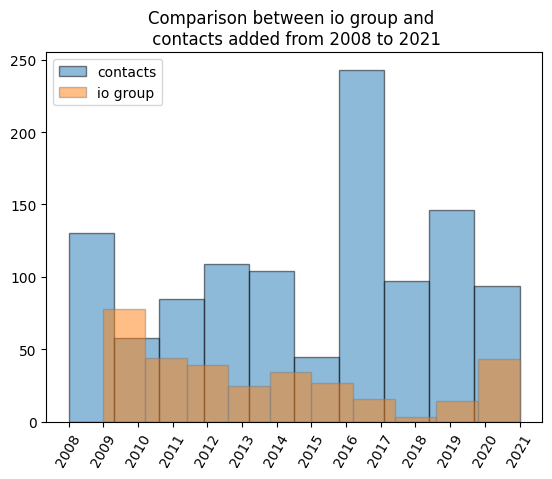

In [26]:
plt.hist(data=contacts_cleaned, x="Year", alpha=0.5, label='contacts', edgecolor = "black")
plt.hist(data=io_group, x="Year", alpha=0.5, label='io group', edgecolor = "grey")
plt.xticks(rotation=60)
plt.legend(loc='upper left')
plt.title("Comparison between io group and \n contacts added from 2008 to 2021")
plt.show()

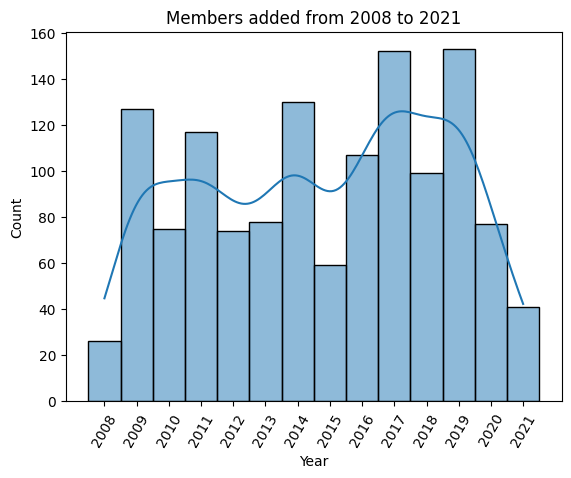

In [27]:
sns.histplot(contacts_merged, x='Year', kde=True)
plt.xticks(rotation=60)
plt.title("Members added from 2008 to 2021");

In [28]:
for_viz = contacts_merged.groupby("Year").count().reset_index()
for_viz = for_viz.rename(columns={"Date Added": "Count"})

In [29]:
DeepnoteChart(for_viz, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"trail","color":"#83bcb6","tooltip":true},"encoding":{"x":{"sort":null,"type":"nominal","field":"Year","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"Count","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}},{"mark":{"dx":0,"dy":-1,"fill":"black","type":"text","align":"center","baseline":"bottom"},"encoding":{"x":{"sort":null,"type":"nominal","field":"Year","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"Count","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"text":{"sort":null,"type":"quantitative","field":"Count"}}},{"mark":{"size":100,"type":"point","opacity":0,"tooltip":true},"encoding":{"x":{"sort":null,"type":"nominal","field":"Year","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"Count","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}}]}],"title":"Line chart for people added from 2008 to 2021","config":{"legend":{"orient":"top"}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

Now we want to clean the sources of people added. (credited from Jiayin Lin)

- The whole process is to first use a bit of regex to clean out the numerical values in the Source column

- After first round of groupby, use tensorflow to transfer the words into vectors 

- Then use standard inner product distance to decide the similarity between vectors (AKA the vectorized words), stored the result in matrix a

- And then use disjoint set to store indexes of high similarity words and change all the children to the nodes' index

- Finally simplify the source column in the original table and regroupby

In [30]:
# a bit more cleaning to delect numbers and symbols like -- // in the "source" column
# - to generalize the source
contacts_merged["Source"] = contacts_merged["Source"].str.replace('\d+', '')
contacts_merged["Source"] = contacts_merged["Source"].str.replace('[^A-Za-z\s]', '')

/tmp/ipykernel_96/593924820.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  contacts_merged["Source"] = contacts_merged["Source"].str.replace('\d+', '')
/tmp/ipykernel_96/593924820.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  contacts_merged["Source"] = contacts_merged["Source"].str.replace('[^A-Za-z\s]', '')


In [31]:
temp = contacts_merged.groupby("Source").count().reset_index()
temparr= temp["Source"].array
selector = [x for x in temparr]

In [32]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
ts = embed(selector)

2023-05-02 23:32:30.569615: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-02 23:32:30.569657: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-02 23:32:30.569682: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-fc58b318-5e37-4a34-b350-914804d4063f): /proc/driver/nvidia/version does not exist
2023-05-02 23:32:30.569927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
a = tf.linalg.matmul(ts, ts, transpose_a=False, transpose_b=True)

In [34]:
# BDPNN group and BerkFair are correctly identified to be different (correlation = 0.19)
a[0][2]

<tf.Tensor: shape=(), dtype=float32, numpy=0.19921781>

In [35]:
# BerkFair and Berkeley Fair are incorrectly identified to be different (correlation = 0.2)
a[2][3]

<tf.Tensor: shape=(), dtype=float32, numpy=0.20630625>

In [36]:
# via email and via email Lynn are successfully identified to be the same (correlation = 0.72)
a[134][135]

<tf.Tensor: shape=(), dtype=float32, numpy=0.72057605>

We will use 0.6 to be the line: correlation >= 0.6: same;  correlation < 0.6: different

In [37]:
dic = {}
for i in range(a.numpy().shape[0]):
    for j in range(i+1, a.numpy().shape[1]):
        dic[(i,j)] = a[i][j]

lstdic = list(dic.keys())
lstdic.sort(key=lambda x:-dic[x])

In [38]:
disjset = [i for i in range(a.numpy().shape[0])]
for ij in lstdic:
    if dic[ij] < 0.6:
        break
    for k in range(len(disjset)):
        if disjset[k] == disjset[ij[1]]:
            disjset[k] = disjset[ij[0]]

Based on USE (Universal Sentence Encoder), we now have below unique sources!

In [40]:
[temp["Source"][i] for i in set(disjset)]

['BDPNN group',
 'via Lerlin ',
 'BerkFair ',
 'Berkeley Fair ',
 'CC listLynn',
 'CERT ',
 'CN contact',
 'Cache list',
 'City OES',
 'Citywide meeting ',
 'Community Fair ',
 'District  Town Hall',
 'EmPrep event ',
 'Email ',
 'Email  replaces Liz Montgomery',
 'Email Bill Swartz ',
 'Email Dave Peattie',
 'Email M Thunen',
 'Email from SG ',
 'Email to Pams trainees',
 'Email via Cordula',
 'Email via K Englund',
 'EmailLynn',
 'EmailPG list ',
 'EmailPam Grossman',
 'EmailQuest ',
 'Emailquestion ',
 'Emailquestionnaire',
 'GoKit sales ',
 'Health Fair SP Park ',
 'Jbuckley ',
 'John Pardee E',
 'Juneteenth ',
 'LeConte Fair ',
 'LeConte FairOakland Core',
 'Linden block email ',
 'MLK Harvest Fair ',
 'Mike HoeyNatl Night Out',
 'Mtg BerkFair Comm Fair',
 'New group form',
 'Norinedrill',
 'Orig CN list',
 'Pam Grossman',
 'Pam GrossmanNorCal Resilience',
 'PamGrossman',
 'Quest request',
 'Radio ',
 'Request Brodergrp leader',
 'Resiliency Fair ',
 'Rumford dedication',
 'Samdy 

In [41]:
len(disjset)

139

In [42]:
ind = 0
for item in disjset:
    temp["Source"][ind] = temp["Source"][item]
    ind += 1

/tmp/ipykernel_96/1543022187.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Source"][ind] = temp["Source"][item]


In [43]:
contact_source = temp[["Source", "index"]].groupby("Source").sum().rename(columns={"index": "Count"})\
.reset_index().sort_values("Count", ascending = False)
contact_source.head(5)

,Source,Count
8,Citywide meeting,326
15,Email M Thunen,214
50,Solano StrMtg,139
21,EmailPam Grossman,79
9,Community Fair,46


We found that there are a lot of "Email ..." sources, so we can generalize them all into "Email" 

Similarly, we want to generalize "xxxfair" to "Fair"  -> Regex again...

In [44]:
contact_source["Source"] = contact_source["Source"].str.replace('.*[Ee]mail.*', 'Email')
contact_source["Source"] = contact_source["Source"].str.replace('.*[Ff]air.*', 'Fair')
contact_source["Source"] = contact_source["Source"].str.replace('.*[Tt]rain.*', 'Training')

/tmp/ipykernel_96/3159629843.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  contact_source["Source"] = contact_source["Source"].str.replace('.*[Ee]mail.*', 'Email')
/tmp/ipykernel_96/3159629843.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  contact_source["Source"] = contact_source["Source"].str.replace('.*[Ff]air.*', 'Fair')
/tmp/ipykernel_96/3159629843.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  contact_source["Source"] = contact_source["Source"].str.replace('.*[Tt]rain.*', 'Training')


In [45]:
contact_source = contact_source.groupby("Source").sum().rename(columns={"index": "Count"})\
.reset_index().sort_values("Count", ascending = False)
contact_source

,Source,Count
6,Citywide meeting,326
9,Email,318
10,Fair,143
27,Solano StrMtg,139
11,GoKit sales,28
18,Orig CN list,25
24,Rumford dedication,16
2,CERT,13
4,Cache list,10
31,TONA,9


In [46]:
contact_source.to_csv("contact_source.csv")

In [47]:
DeepnoteChart(contact_source, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"circle","color":"#4c78a8","tooltip":true},"encoding":{"x":{"axis":{"title":"Source"},"sort":null,"type":"nominal","field":"Source","scale":{"type":"linear","zero":false}},"y":{"axis":{"title":"Count(log)"},"sort":null,"type":"quantitative","field":"Count","scale":{"type":"log","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}}]}],"title":"Source of contacts added","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

If we only keep the top 10 sources, then the data and graph look like:

In [48]:
contact_source = contact_source.head(10)

In [49]:
DeepnoteChart(contact_source, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","color":"#4c78a8","tooltip":true},"encoding":{"x":{"sort":null,"type":"nominal","field":"Source","scale":{"type":"linear"}},"y":{"axis":{"title":"Count"},"sort":null,"type":"quantitative","field":"Count","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"}}},{"mark":{"dx":0,"dy":-1,"fill":"black","type":"text","align":"center","baseline":"bottom"},"encoding":{"x":{"sort":null,"type":"nominal","field":"Source","scale":{"type":"linear"}},"y":{"axis":{"title":"Count"},"sort":null,"type":"quantitative","field":"Count","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"text":{"sort":null,"type":"quantitative","field":"Count","aggregate":"sum"}}}]}],"title":"Top 10 sources of contacts added","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

In [50]:
contacts_merged["Source"] = contacts_merged["Source"].str.replace('.*[Ee]mail.*', 'Email')
contacts_merged["Source"] = contacts_merged["Source"].str.replace('.*[Ff]air.*', 'Fair')
contacts_merged["Source"] = contacts_merged["Source"].str.replace('.*[Tt]rain.*', 'Training')

/tmp/ipykernel_96/3000808784.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  contacts_merged["Source"] = contacts_merged["Source"].str.replace('.*[Ee]mail.*', 'Email')
/tmp/ipykernel_96/3000808784.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  contacts_merged["Source"] = contacts_merged["Source"].str.replace('.*[Ff]air.*', 'Fair')
/tmp/ipykernel_96/3000808784.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  contacts_merged["Source"] = contacts_merged["Source"].str.replace('.*[Tt]rain.*', 'Training')


In [51]:
contacts_merged

,index,ContactID,GroupID,ContactName,ContactRole,ContactAddress,Contact cross streets,ContactZip,ContactCity,ContactPhone1,ContactPhone2,ContactEmail1-Master,Date Added,Source,DiscGrp Io,Date,Final Address,ioName-in Contacts,Year
1093,329,14,D35,"Freed, Ellen B",Block Captain,NaN,NaN,NaN,Berkeley,NaN,NaN,EBFreed@aol.com,7/9/2008,Orig CN list,no,2008-07-09,NaN,NaN,2008
1109,403,101,ZZ9,"Grossman, Pam",NaN,NaN,NaN,NaN,NaN,510-526-9614,510-703-8939,pam@grossmanfamily.com,7/8/2008,Orig CN list,yes,2008-07-08,NaN,NaN,2008
1108,975,5,N78,"Thompson, Daniella",Webmaster,NaN,NaN,NaN,Berkeley,NaN,NaN,dt@daniellathompson.com,7/8/2008,Orig CN list,yes,2008-07-08,NaN,NaN,2008
1107,935,1,S16,"Stark, David",Block Captain,1325 Santa Fe,NaN,NaN,Berkeley,510-525-7072,510-841-6010,info@stileshall.org,7/8/2008,Orig CN list,no,2008-07-08,"1325 Santa Fe, Berkeley, CA",NaN,2008
1106,990,4,N78,"Trippe, Tom",Captain,1551 La Vereda Rd,NaN,94708,Berkeley,510-529-5721,510-841-0262,trippe@dslextreme.com,7/8/2008,Orig CN list,yes,2008-07-08,"1551 La Vereda Rd, Berkeley, CA",NaN,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,998,1587,N78,"Umeda, Takato",NaN,1643 Le Roy Ave,Hilgard Avenue,94709,Berkeley,510,510,takato@sonic.net,3/30/2021,Website,no,2021-03-30,"1643 Le Roy Ave, Berkeley, CA",NaN,2021
23,212,1588,H22,"Dara-Abrams, Benay",NaN,2511 Hill Court,Euclid/Hill Court Steps,94708,Berkeley,510,510,benay@dara-abrams.com,3/30/2021,Website,no,2021-03-30,"2511 Hill Court, Berkeley, CA",NaN,2021
22,989,1590,C14,Trigger. Suzette,NaN,1500 Campus Drive,Avenida/Parnassus,94708,Berkeley,510,510,sftrigger@gmail.com,4/6/2021,Website,no,2021-04-06,"1500 Campus Drive, Berkeley, CA",NaN,2021
20,910,1592,S89.6,"Snippen, David",NaN,1834 Sonoma Avenue,Fresno/Josephine,94707,Berkeley,510,510,dsnppn28@gmail.com,4/18/2021,Website,no,2021-04-18,"1834 Sonoma Avenue, Berkeley, CA",NaN,2021


In [52]:
contacts_merged.to_csv("contacts_merged.csv")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fc58b318-5e37-4a34-b350-914804d4063f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>